# Neural networks with PyTorch

딥러닝 네트워크는 수십개에서 수백개의 레이어로 되어서 deep이라고 불린다. 당신은 저번 시간에 배운 weight matrix만으로 이 딥 네트워크 중 하나를 build할 수 있다. 그러나 일반적으로 이런 방법으로 implement하기가 어렵다. pytorch는 거대한 뉴럴넷을 효과적으로 만들기 위해 `nn`이라는 좋은 모듈을 가지고 있다.

In [1]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt


이제 우리는(formaly) 어려운 문제를 풀 수 있는 더 거대한 네트워크를 만들 것인데, 이 문제는 이미지의 텍스트를 분간하는 과제입니다. 여기서 우리는 MNIST 데이터를 쓸 것입니다. 이 데이터셋은 손으로 쓴 흑백 색상의 숫자로 이루어 졌습니다. 각 이미지는 28X28개의 픽셀입니다. 아래에서 확인할 수 있죠.

<img src='assets/mnist.png'>

우리의 목표는 뉴럴 네트워크를 만들어서 이 이미지 중 하나를 가져와 이 숫자를 예측할 수 있게 하는 것입니다. 

첫번째로, 우리는 우리의 데이터셋을 가져와야합니다. `touchvision` package에서 제공됩니다. 아래 코드는 MNIST dataset을 가져와서 training과 test 데이터셋으로 만들어줍니다. 자세한건 걱정할 거 없습니다. 이것에 대해서는 나중에 배울 것입니다. 



In [2]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])


In [3]:
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

당신은 `trainloader`를 ```64의 batch size```로, `shuffle=True`로 만들었다는 사실을 알아차렸을 것입니다.

```python
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
<torch.utils.data.dataloader.DataLoader at 0x7f5cf9205710>
```


1. ```batch size``` 란 **한번의 iteration(=하나의 batch)** 에서 보는 image의 개수로, *batch*라고도 합니다.
2. ```shuffle=True``` 란 data loader를 시작할 때마다 데이터셋을 섞는 것입니다.

But here I'm just grabbing the first batch so we can check out the data. 
`images`는 `(64,1,28,28)`사이즈의 tensor이다. 이는 하나의 batch 당 ```64개의 이미지```를, ```1차원의 색상 채널```로, ```28X28 픽셀``` 이미지로 본다는 뜻입니다.

In [4]:
#1개의 batch에서 사용할 데이터를 얻어보도록 하겠습니다. 
# x (데이터개수, 픽셀 차원, 픽셀 가로, 픽셀 세로)
# label (데이터개수)

dataiter = iter(trainloader) #<torch.utils.data.dataloader._DataLoaderIter at 0x7f5cf922fe80>
images, labels = dataiter.next() #tensor: images(64,1,28,28), labels(64)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


방금 우리는 `trainloader`에 트레이닝 데이터를 로딩하였고, `iter(trainloader)`를 통해 iterator를 만들었습니다. 나중에 이 loop를 통해 데이터셋을 돌려서 training할 것입니다. 아래처럼요.

```python
for image, label in trainloader:
    ## do things with images and labels
```


한장의 이미지는 다음과 같이 생겨먹었습니다.

torch.Tensor

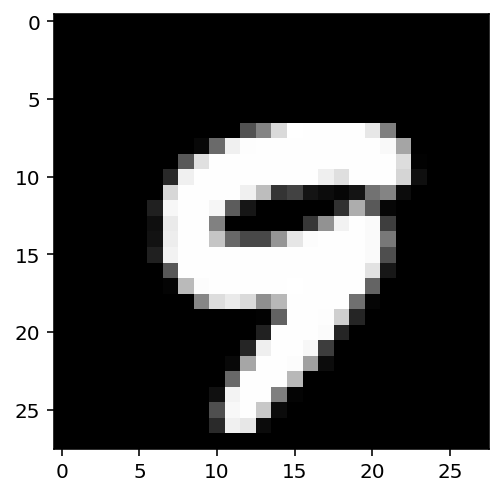

In [5]:
#64장의 이미지중 하나 골라서 넘파이로 변환한 후 -> (1,28,28)
#.squeeze() -> (28,28)
plt.imshow(images[2].numpy().squeeze(), cmap='Greys_r')
type(images)

1 - weight matrix와 matrix 곱셈을 통해 간단한 네트워크를 만들어 봅시다. 

2 - 그리고 나서 우리는 pytorch의 `nn` 모듈을 사용해서 더 간단하고 파워풀한 방법으로 network 구조를 정의할 것입니다. 

여태까지 우리가 본 네트워크들은 모두 *fully-connected* 또는 *dense* 네트워크였습니다. 

- fully-connected(dense): 하나의 layer 안의 각 유닛들은 다음 레이어의 각 유닛에 연결됩니다. fc 네트워크에서는, 각 layer에 대한 input이 1차원의 벡터여야합니다 (이 벡터는 여러가지 example로 구성된 하나의 batch로서, 2d tensor에 stack될 수 있음) 

그러나 28X28 2D tensor이기 때문에, 우리는 1D vector로 변환할 필요가 있습니다. 사이즈를 고려해본다면, 우리는 `(64,1,28,28)` 모양의 이미지들로 구성된 하나의 batch를 `(64,784)`, 즉 `(데이터개수,1차원벡터크기)` 모양으로 변환할 필요가 있습니다. 이것은 *flattening*이라고 부릅니다. 우리는 2d이미지를 1d 벡터로 변환한 것입니다. 

전에 우리는 1개의 output유닛을 가진 network를 만들었습니다만, 이번에 우리는 10개의 output유닛이 필요합니다. 왜냐면 0~9까지 각각의 숫자에 대해서 필요하기 때문입니다. 우리는 네트워크를 통해 이미지의 digit을 예측하고 싶기 때문에, 각 digit(class)에 속할 확률을 계산할 것입니다. 이것은 digit(class)에 대한 discrete probability distribution의 결과를 낼 것이며, 가장 속할 확률이 높은 class를 알려줄 것입니다. 이것은 10개의 output unit이 필요함을 뜻합니다. 그래서 network output을 어떻게 probability distribution으로 변환할지를 볼 것입니다. 

> **Exercise:** `images` (이미지들의 batch한개)를 flatten하세요. 그리고 ```784개의 input unit``` 과 ```256개의 hidden unit```과 ```10개의 output unit```을 가진 multi-layer 네트워크를 구축하세요. hidden layer에 대해서는 sigmoid activation 함수를 사용하세요. output layer는 activation하지 말고 두세요. 나중에 probability distribution으로 변환할 겁니다. 

In [6]:
## Solution
def activation(x):
    return 1/(1+torch.exp(-x))

# Flatten the input images
inputs = images.view(images.shape[0], -1) #images.view(64,-1) -1는 알아서 한다.

# Create parameters
w1 = torch.randn(784, 256)
b1 = torch.randn(256)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1) + b1)

out = torch.mm(h, w2) + b2

In [7]:
w1.shape,b1.shape,w2.shape,b2.shape,h.shape,out.shape

(torch.Size([784, 256]),
 torch.Size([256]),
 torch.Size([256, 10]),
 torch.Size([10]),
 torch.Size([64, 256]),
 torch.Size([64, 10]))

## 모델의 크기

64장의 이미지

images=(64,784)

64장의 이미지 중 한장을 가지고 가정해보면,
한장의 이미지는 flatten된 784차원의 벡터. ```(784)```

784X256 매트릭스 w1은 256차원의 중간결과가 목적임. ```w1=(784,256), b1=(256)```

그래서 1/784 각 input 픽셀에 대해 256가지 결과를 낸다. 
256의 경우의 수마다 input x1~x784에 대한 784개 결과를 모두 더함
그래서 중간 결과 h1은 256차원의 벡터가 됨.
즉, h1은 784 대신 256개의 픽셀로 변환된 것. ```h1=(64,256)```

256X10 매트릭스 w2는 10차원의 output 목적임.```w2=(256,10) , b2=(10)```

그래서 1/256 각 input 픽셀에 대해 10가지 결과를 낸다. 
10의 경우의 수마다 input x1~x256에 대한 256개 결과를 모두 더함
그래서 output은 10차원의 벡터가 됨.```out=(64,10)```


우리의 네트워크를 위한 10개의 output을 가지고 있다. 우리는 우리의 network에 image를 전달하고 probability distribution을 얻고 싶다. :

<img src='assets/image_distribution.png' width=500px>

여기서 우리는 각 class에 대한 확률이 비슷함을 볼 수 있다. 이것은 아직 트레인되지 않은 network이다. 그래서 각 클래스에 대해 비슷한 확률을 보여주는 것이다. 

이 probability distribution을 계산하기 위해, [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function). 를 이용할 것이다. 

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

0에서 1사이의 input을 찌그러뜨려서 normalize하여 적절한 probability distribution을 제공하여 합이 1이 되게끔한다. 

> **Exercise:** `softmax` 함수를 실행해서 softmax calculation을 하고 probability distribution을 리턴하게 하세요. 만약 `(64,10)` 사이즈의 `a`라는 tensor를 가지고 있고, `(64,)`사이즈의 `b` tensor를 가지고 있으면, `a/b`는 error가 뜰 것입니다. 왜냐하면 사이즈가 맞지 않기 때문입니다. 따라서 `b`를 `(64,1)`사이즈로 만들 필요가 있습니다. 또한, 그 결과 tensor인 probability의 원소 합이 1이 되는 것을 확인해보세요. tensor의 합을 구할때, `dim`키워드를 신경써야 합니다. `dim=0`이면 세로로 더합니다 (= column단위로 더합니다 = across row로 더합니다 = 각 row를 더합니다) 반면 `dim=0`이면 가로로 더합니다 (=row단위로 더합니다 = across column으로 더합니다 = 각 column을 더합니다) 우리는 `dim=1`로 더해야합니다. 각 이미지별로(row별로) 확률을 구하기 때문이죠.

In [8]:
out.shape

torch.Size([64, 10])

In [9]:
torch.exp(out).shape
torch.exp(out).shape
torch.sum(torch.exp(out), dim=1).shape


torch.Size([64])

In [10]:
## Solution
def softmax(x):#x는 64장 이미지 X 10차원 -> 각 원소에 대해 계산함 64 X 10차원
    #torch.exp(out) : (64,10) 
    #torch.sum((64,10), dim=1) : (64) row단위로 더함
    #(64).view(-1,1) : (64,1)
    #(64,10)/(64,10) : (64,10)    
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

probabilities = softmax(out)

# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)

# Does it sum to 1?
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Building networks with PyTorch

pytorch는 `nn` 모듈을 제공한다. 이것은 network를 훨 간단하게 해준다. 여기 나는 위에서 만든 네트워크와 같은 것을 어떻게 만드는지 보여줄 것이다 (784차원 input, 256개의 hidden unit, 10개의 output unit, 10개의 softmax output)


In [9]:
from torch import nn

In [10]:
class Network(nn.Module): 
    def __init__(self): 
        super().__init__() #nn.Module로부터 상속받습니다
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x): #x는 tensor
        
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

하나씩 살펴보죠.

```python
class Network(nn.Module):
```

`nn.Module`이라는 클래스를 상속받았습니다. `super().__init__()`와 결합해서 class를 만드는데요, 이것은 구조를 트랙킹하고 유용한 함수와 attribute을 제공합니다. `nn.Module`로부터 상속받는 것은 필수입니다. 


```python
self.hidden = nn.Linear(784, 256)
```

위 코드는 linear transformation (선형 변환)을 위한 모듈을 만들어줍니다. ($x\mathbf{W} + b$) 784개의 input을 받아 256개의 output을 뱉어내는 선형 변환이죠. 그 결과는 `self.hidden`에 저장시킵니다. 모듈은 자동으로 weight과 bias tensor를 만들어주는데, 이때 `forward`함수를 쓸 것입니다. 당신은 network (`net`)를 생성한후 `net.hidden.weight`와 `net.hidden.bias`를 통해 weight과 bias에 access할 수 있습니다.  

```python
self.output = nn.Linear(256, 10)
```

위 코드는 또다른 linear transformation을 만들어주는데, 256개의 input을 받아서 10개의 output을 뱉어내줍니다. 

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

위 코드는 sigmoid activation과 softmax output을 위한 operation을 정의하는 것입니다. `dim=1`을 설정하는 것은 softmax가 row단위(across the columns)로 계산하게 설정하는 것입니다. 


```python
def forward(self, x):
```

`nn.Module`로 만든 pytorch network는 반드시 `forward` 함수를 정의해줘야합니다. tensor `x`를 받아서 `__init__` 함수에서 정의한 operation을 통과시킵니다. 


```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

위 코드에서 input tensor `x`는 각 operation을 통과해서 `x`에 reassign됩니다. input tensor가 hidden layer를 통과한 후, sigmoid 함수를 거치고, output layer를 거쳐서, 마지막으로 softmax function을 거칩니다. 여기서 당신이 variable의 이름을 어떻게 짓는지는 상관없습니다. input과 output이 네트워크 구조에 맞기만 하면 됩니다. `__init__`에서 정의하는 순서도 중요치 않지만, `forward`에서의 operation 순서는 맞춰야합니다. 

Now we can create a `Network` object.

In [13]:
# Create the network and look at it's text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

`torch.nn.functional` 모듈을 써서 더 consise하고 clear하게 network 정의할 수 있습니다. 보통 이 모듈을 `F`로 import해서 씁니다.  `import torch.nn.functional as F`

In [14]:
import torch.nn.functional as F

class Network(nn.Module):
    
    def __init__(self): #함수를 정의할 필요가 없음. 
        
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
    def forward(self, x): 
        
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x)) ################## sigmoid함수 : F.sigmoid사용
        
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1) #################### softmax함수 : F.softmax사용
        
        return x

### Activation functions

여태까지는 softmax만 봤지만, 다른 것을 써도 된다. 다만, non-linear function이어야한다. 다른 예는 : Tanh (hyperbolic tangent), and ReLU (rectified linear unit

<img src="assets/activation.png" width=700px>

ReLU 함수가 hidden layer에서는 가장 빈번하게 사용된다. 

### Your Turn to Build a Network

<img src="assets/mlp_mnist.png" width=600px>

> **Exercise:** 
다음 네트워크를 만들어주세요. 784개의 input unit을 가졌으며, 128유닛과 ReLU activation을 거치는 hidden layer 1을 가졌으며, 64개의 unit과 ReLU activation을 거치는 hidden layer 2를 가졌으며, 마지막으로 softmax activation을 가지는 output layer를 가집니다. 당신은 `nn.ReLU`나 `F.relu`를 쓸 수 있습니다. 




In [15]:
## Solution

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

    
#my answer
from torch import nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__() #nn.Module을 상속받음. 
        
        self.h1=nn.Linear(784,128) #nn.Linear: linear transformation(선형 변환) ~ in:784차원 -> out:128차원 
        
        print('nn.Linear(784,128)',self.h1) 
        
        self.h2=nn.Linear(128,64) 
        
        print('nn.Linear(128,64)',self.h2)
        
        self.out=nn.Linear(64,10)

        print('nn.Linear(64,10)',self.out)

    def forward(self,x):
        
        ''' Forward pass through the network, returns the output logits '''
        
        x=self.h1(x) #input tensor는 784->128로 만드는 선형변환을 거침. 
        x=F.relu(x) #128차원은 relu함수로 activate됨. 
        x=self.h2(x) #128차원은 64차원으로 선형변환을 거침
        x=F.relu(x)
        x=self.out(x)
        x=F.softmax(x,dim=1)
        
        return x
    
model = Network()
model

nn.Linear(784,128) Linear(in_features=784, out_features=128, bias=True)
nn.Linear(128,64) Linear(in_features=128, out_features=64, bias=True)
nn.Linear(64,10) Linear(in_features=64, out_features=10, bias=True)


Network(
  (h1): Linear(in_features=784, out_features=128, bias=True)
  (h2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

weight가 자동으로 초기화되는 방식을 커스터마이즈할 수 있습니다. weights와 bias는 당신이 정의한 layer에 attach되어 있습니다. 당신은 `model.h1.weight`를 통해 hidden layer 1(=h1)에 해당하는 weight를 얻을 수 있습니다. 


In [16]:
print(model.h1.weight) 
print(model.h1.bias)

Parameter containing:
tensor([[-0.0016, -0.0317,  0.0007,  ...,  0.0294, -0.0314, -0.0264],
        [ 0.0057, -0.0014,  0.0097,  ...,  0.0119, -0.0349, -0.0231],
        [-0.0316, -0.0350, -0.0046,  ..., -0.0225, -0.0105, -0.0261],
        ...,
        [ 0.0170,  0.0221, -0.0081,  ...,  0.0162, -0.0026,  0.0351],
        [ 0.0178, -0.0065,  0.0142,  ...,  0.0314,  0.0104, -0.0233],
        [-0.0231, -0.0194,  0.0151,  ...,  0.0022,  0.0021, -0.0194]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0215, -0.0095, -0.0328,  0.0018,  0.0275, -0.0117,  0.0116, -0.0047,
        -0.0023,  0.0040,  0.0267, -0.0004,  0.0350, -0.0071, -0.0110, -0.0250,
        -0.0043, -0.0166, -0.0137,  0.0209, -0.0356, -0.0057,  0.0302,  0.0051,
        -0.0338,  0.0124, -0.0076,  0.0340,  0.0106, -0.0183,  0.0290,  0.0259,
        -0.0002, -0.0344,  0.0067,  0.0322,  0.0225, -0.0287, -0.0255,  0.0155,
         0.0314,  0.0166, -0.0331, -0.0236, -0.0226, -0.0092, -0.0246, -0.0216,
         0.0147

초기화를 커스텀하기 위해서, 우리는 이 텐서들을 변형시키고 싶습니다. 이것들은 *Variables*입니다. 즉 우리는 `model.h1.weight.data`를 통해 실제 tensor에 get back할 필요가 있습니다. 우리가 tensor를 한번 가지면, 우리는 0으로 채우거나 random normal value로 채울 수 있습니다. 




In [17]:
# Set biases to all zeros
#.fill_(0)
model.h1.bias.data.fill_(0)
#model.h1.bias(parameter).data(tensor)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
# sample from random normal with standard dev = 0.01
#.normal_(std=0.01)
model.h1.weight.data.normal_(std=0.01)

tensor([[-0.0135, -0.0045, -0.0079,  ..., -0.0012, -0.0114, -0.0061],
        [ 0.0074,  0.0090, -0.0033,  ...,  0.0048, -0.0158,  0.0121],
        [-0.0068, -0.0096,  0.0042,  ..., -0.0079, -0.0082,  0.0036],
        ...,
        [-0.0011, -0.0064,  0.0024,  ...,  0.0177, -0.0078,  0.0068],
        [ 0.0120, -0.0078, -0.0068,  ..., -0.0167, -0.0076, -0.0063],
        [ 0.0034, -0.0063,  0.0014,  ..., -0.0119, -0.0038,  0.0046]])

### Forward pass

우리는 네트워크를 가지고 있으니, 이미지에서 무슨 일이 일어나는지 살펴보죠

In [19]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()
images.shape,labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [20]:
# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size
images.shape


torch.Size([64, 1, 784])

In [21]:
# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:]) #model.forward(torch.Size([1,784]))


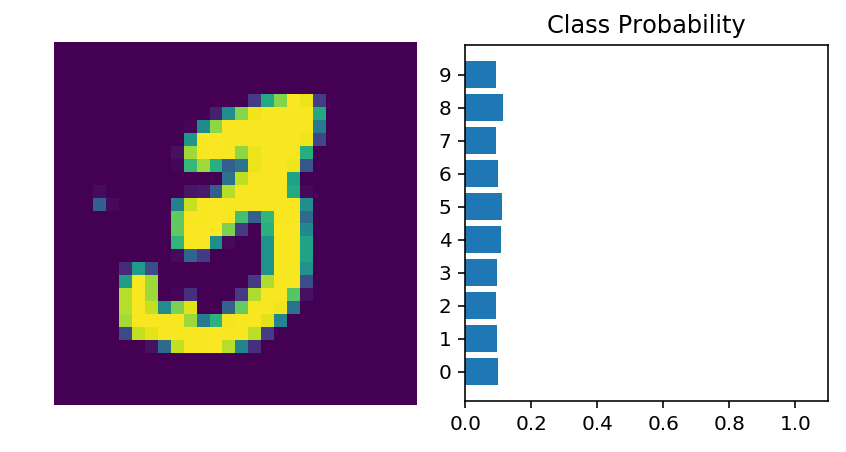

In [22]:
img = images[img_idx] #0번째 이미지

#helper.view_classify(img, ps, version="MNIST"): Function for viewing an image and it's predicted classes.
#왼쪽은 그림이고, 오른쪽은 ps (model을 통해 도출해낸 확률 분포)
helper.view_classify(img.view(1, 28, 28), ps) #0번째 이미지의 픽셀을 그림그려보면..

위에서 볼 수 있는 것은, 우리의 네트워크가 이 숫자가 무엇인지 아무 생각이 없다는 것이다. 왜냐하면, 우리는 아직 트레이닝하지 않았기 때문에 모든 weights는 random인 상태이다. 

### Using `nn.Sequential`

pytorch에서는 operation을 통해 연속적으로 tensor를 전달하는 network를 만드는 편리한 방식을 제공한다.  `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). equivalent network를 만들 수 있다. 




Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


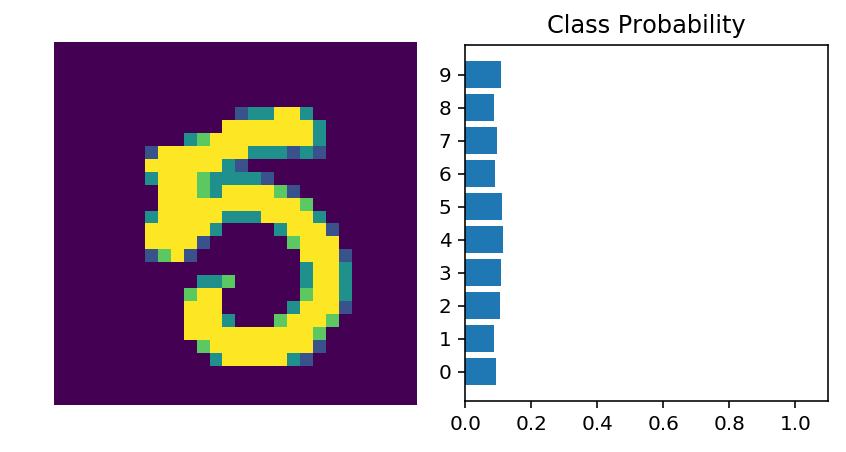

In [35]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

operation은 적절한 index를 전달함으로써 사용 가능하다. 예를 들어, 첫번째 Linear operation에 접근해서 weight를 보고 싶다면, `model[0]`을 사용하면 된다.

In [36]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[ 0.0049,  0.0151, -0.0158,  ...,  0.0059, -0.0029, -0.0263],
        [ 0.0135,  0.0331,  0.0261,  ..., -0.0234, -0.0350,  0.0058],
        [-0.0120, -0.0326,  0.0256,  ...,  0.0281,  0.0006, -0.0344],
        ...,
        [-0.0052,  0.0317, -0.0139,  ..., -0.0295, -0.0125, -0.0050],
        [-0.0116,  0.0335, -0.0223,  ..., -0.0307,  0.0338,  0.0133],
        [-0.0138, -0.0307, -0.0089,  ..., -0.0355, -0.0178,  0.0332]],
       requires_grad=True)

`OrderedDict`를 쓰면 각각의 layer와 operation을 이름 붙일 수 있다. (incremental integer를 사용하지 않아도되게 됨). dictionary key는 unique해한다, 즉, _각 operation은 서로 다른 이름을 붙여야한다_.



In [38]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

Now you can access layers either by integer or the name

In [39]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


In the next notebook, we'll see how we can train a neural network to accuractly predict the numbers appearing in the MNIST images.